# 2nd order servo model

* instead of full state x observation, only position can be observed

In [119]:
import numpy
import scipy.linalg
import matplotlib.pyplot as plt

#2nd order state space model
#dx = Ax + Bu
#y  = Cx

#dv   = -1.0/tau*v + amp/tau*u
#dpos = v

tau = 1.9
amp = 3.1

#fill matrices
a = numpy.zeros((2, 2))
b = numpy.zeros((2, 1))
c = numpy.zeros((1, 2))

a[0][0] = -1.0/tau
a[0][1] = 0.0
a[1][0] = 1.0
a[1][1] = 0.0

b[0][0] = amp/tau

c[0][1] = a[1][0]

print(a)
print(b)
print(c)

[[-0.52631579  0.        ]
 [ 1.          0.        ]]
[[1.63157895]
 [0.        ]]
[[0. 1.]]


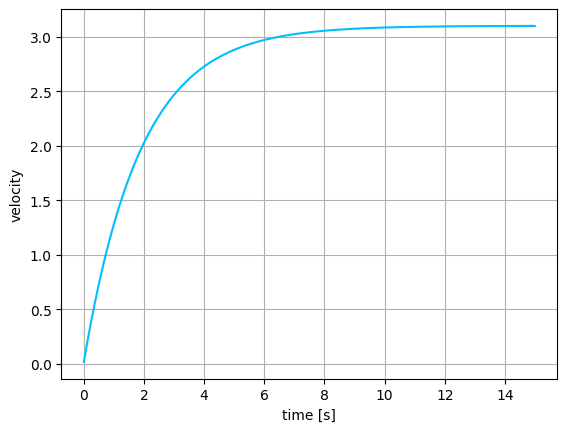

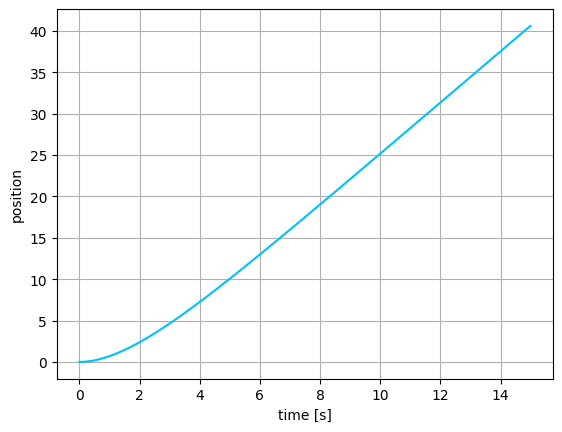

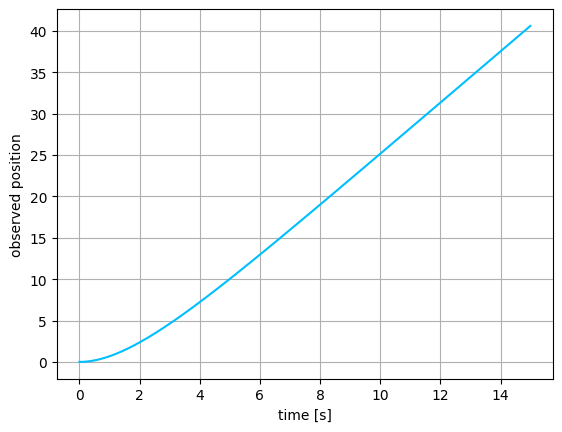

In [120]:
#open loop step response
dt          = 0.01
steps       = 1500
t_result    = numpy.arange(steps)*dt

#initial state
x           = numpy.zeros((2, 1))

#resulted states for ploting
x_result    = numpy.zeros((steps, 2))
y_result    = numpy.zeros((steps, 1))

for i in range(steps):
    u = numpy.ones((1, 1))

    dx = a@x + b@u
    y  = c@x
    x  = x + dx*dt
    
    x_result[i] = x[:, 0]
    y_result[i] = y[:, 0]

#plot step response
plt.clf()
plt.ylabel("velocity")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 0], color="deepskyblue")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("position")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 1], color="deepskyblue")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("observed position")
plt.xlabel("time [s]")
plt.plot(t_result, y_result[:, 0], color="deepskyblue")
plt.grid()
plt.show()

# LQG controller design

## controller structure 

![diagram](../doc/diagrams/control-lqg.png)


algorithm : 
* given system dynamics : matrices A, B, C
* given weighting for controlled state, Q matrix
* given weighting for controll signal u, R matrix
* given observatio noise matrix W
* - matrices Q, R and W are mostly diagonal

* **same as LQR**
* using Riccati equation compute matrix K
* this matrix stabiles system
* using steady state response with closed loop, compute gain scaling matrix G, which removes steady state error

* **LQG**
* using Riccati equation compute matrix F



In [121]:
#controller criterion : weight diagonal matrices
q = numpy.array([ [0.0, 0.0], [0.0, 1.0] ] )
r = numpy.array( [ [0.5] ]) 
w = numpy.array( [[0.1]] )

In [122]:
#solve LQR controller, matrix K and G

#continnuous algebraic Riccati equation
p = scipy.linalg.solve_continuous_are(a, b, q, r)
# compute the LQR gain matrix k
k =  scipy.linalg.inv(r) * (b.T@p) 

#from stready state compute gain matrix
x_steady_state = -numpy.linalg.pinv(a-b@k)@b@k
g = 1.0/numpy.diagonal(x_steady_state)
g = numpy.expand_dims(g, 1)

#print control matrices
print(k)
print(g)

[[1.03300424 1.41421356]]
[[-5.13216962e+16]
 [ 1.00000000e+00]]


In [123]:
# solve Kalman observer, matrix F

p = scipy.linalg.solve_continuous_are(a.T, c.T, q, w)
f = (p@c.T)@scipy.linalg.inv(w)

f/=2

print(f)

[[0.        ]
 [1.58113883]]


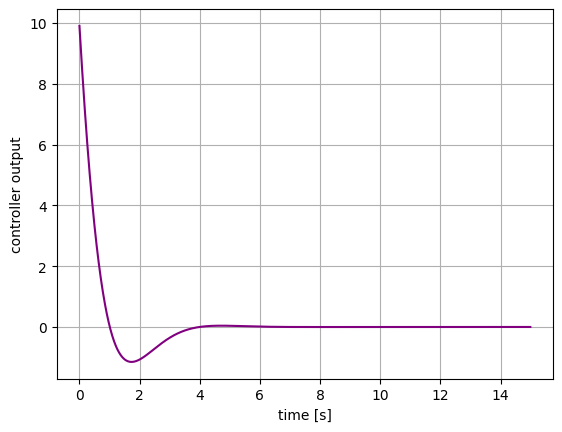

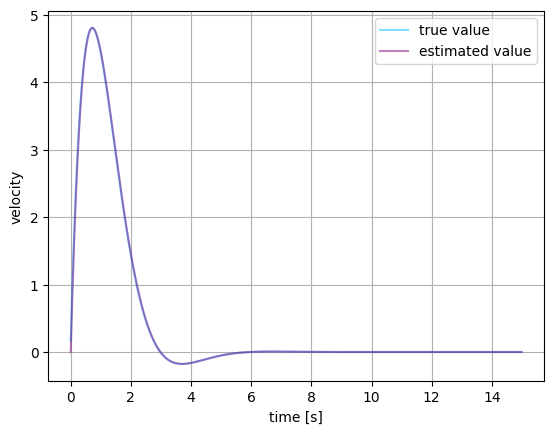

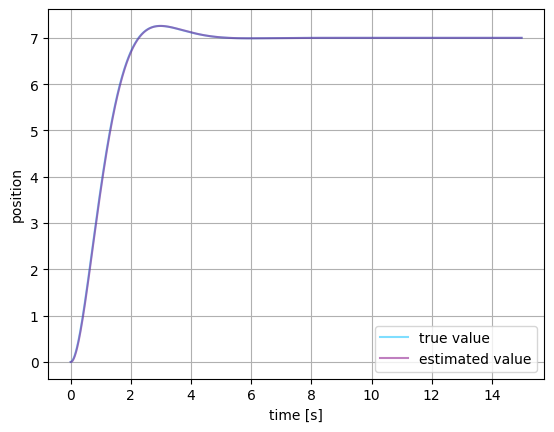

In [124]:
#closed loop step response
dt          = 0.01
steps       = 1500
t_result    = numpy.arange(steps)*dt

#required state, position = 7
xr          = numpy.zeros((2, 1))
xr[1][0]    = 7.0

#initial state
x           = numpy.zeros((2, 1))

#estimated state using Kalman observer
x_hat       = numpy.zeros((2, 1))

#kalman estimator needs observed output and input into plant 
y           = numpy.zeros((1, 1))
u           = numpy.zeros((1, 1))

#resulted states for ploting
u_result        = numpy.zeros((steps, 1))
x_result        = numpy.zeros((steps, 2))
x_hat_result    = numpy.zeros((steps, 2))

for i in range(steps):
    #kalman observer
    #estimate x_hat from observed y, and u
    y_hat   = c@x_hat
    e       = y - y_hat
    dx_hat  = a@x_hat + b@u + f@e
    x_hat   = x_hat + dx_hat*dt

    #apply LQR control law, use estimated x_hat instead of full x
    error = xr*g - x_hat
    u = k@error

    #dynamical system step
    dx = a@x + b@u
    y  = c@x
    x  = x + dx*dt
    
    u_result[i]     = u[0][0]
    x_hat_result[i] = x_hat[:, 0]
    x_result[i]     = x[:, 0]
    y_result[i]     = y[:, 0]

#plot response
plt.clf()
plt.ylabel("controller output")
plt.xlabel("time [s]")
plt.plot(t_result, u_result[:, 0], color="purple")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("velocity")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 0], color="deepskyblue", label = "true value", alpha=0.5)
plt.plot(t_result, x_hat_result[:, 0], color="purple", label = "estimated value", alpha=0.5)
plt.legend()
plt.grid()
plt.show()

plt.clf()
plt.ylabel("position")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 1], color="deepskyblue", label = "true value", alpha=0.5)
plt.plot(t_result, x_hat_result[:, 1], color="purple", label = "estimated value", alpha=0.5)
plt.legend()
plt.grid()
plt.show()

# adding disturbance

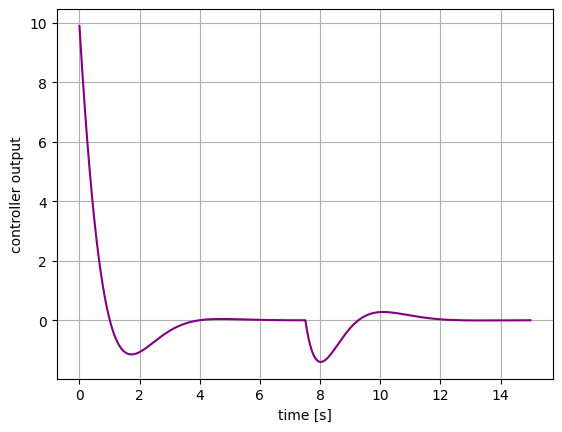

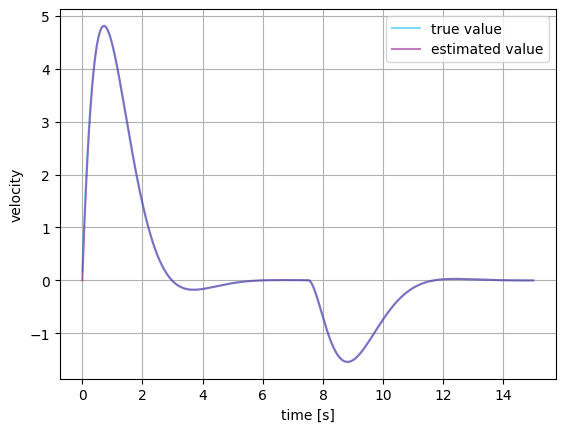

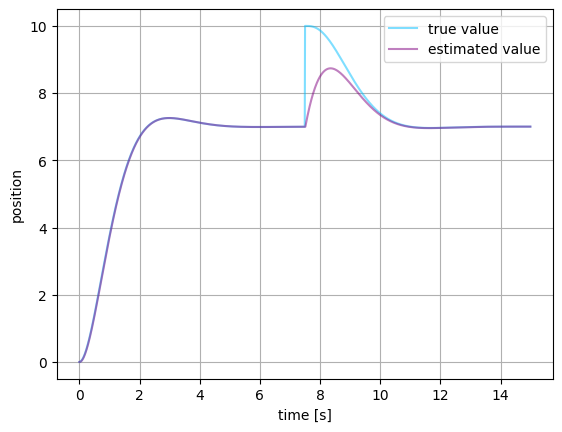

In [125]:
#closed loop step response
dt          = 0.01
steps       = 1500
t_result    = numpy.arange(steps)*dt

#required state, position = 7
xr          = numpy.zeros((2, 1))
xr[1][0]    = 7.0

#initial state
x           = numpy.zeros((2, 1))

#estimated state using Kalman observer
x_hat       = numpy.zeros((2, 1))

#kalman estimator needs observed output and input into plant 
y           = numpy.zeros((1, 1))
u           = numpy.zeros((1, 1))

#resulted states for ploting
u_result        = numpy.zeros((steps, 1))
x_result        = numpy.zeros((steps, 2))
x_hat_result    = numpy.zeros((steps, 2))

for i in range(steps):
    #kalman observer
    #estimate x_hat from observed y, and u
    y_hat   = c@x_hat
    e       = y - y_hat
    dx_hat  = a@x_hat + b@u + f@e
    x_hat   = x_hat + dx_hat*dt

    #apply LQR control law, use estimated x_hat instead of full x
    error   = xr*g - x_hat
    u       = k@error

    #dynamical system step
    dx = a@x + b@u
    y  = c@x
    x  = x + dx*dt

    # !!! disturbance in middle, kick the servo position
    if i == steps//2:
        x[1]+= 3
    
    u_result[i]     = u[0][0]
    x_hat_result[i] = x_hat[:, 0]
    x_result[i]     = x[:, 0]
    y_result[i]     = y[:, 0]

#plot response
plt.clf()
plt.ylabel("controller output")
plt.xlabel("time [s]")
plt.plot(t_result, u_result[:, 0], color="purple")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("velocity")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 0], color="deepskyblue", label = "true value", alpha=0.5)
plt.plot(t_result, x_hat_result[:, 0], color="purple", label = "estimated value", alpha=0.5)
plt.legend()
plt.grid()
plt.show()

plt.clf()
plt.ylabel("position")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 1], color="deepskyblue", label = "true value", alpha=0.5)
plt.plot(t_result, x_hat_result[:, 1], color="purple", label = "estimated value", alpha=0.5)
plt.legend()
plt.grid()
plt.show()

# noisy state

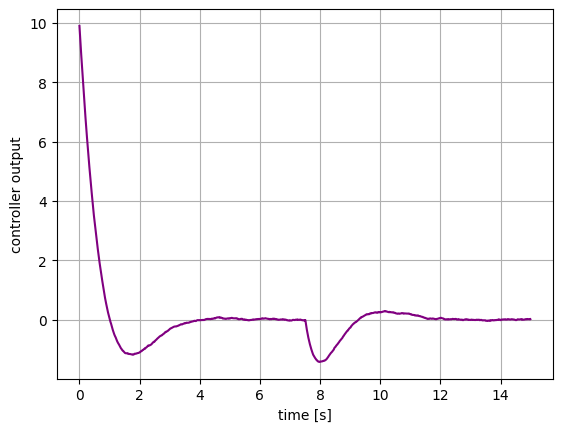

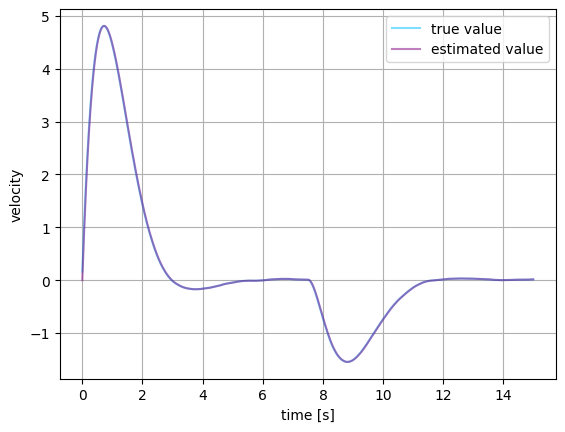

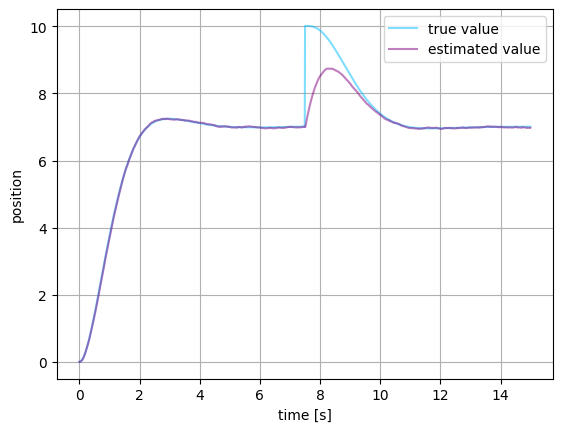

In [127]:
#closed loop step response
dt          = 0.01
steps       = 1500
t_result    = numpy.arange(steps)*dt

#required state, position = 7
xr          = numpy.zeros((2, 1))
xr[1][0]    = 7.0

#initial state
x           = numpy.zeros((2, 1))

#estimated state using Kalman observer
x_hat       = numpy.zeros((2, 1))

#kalman estimator needs observed output and input into plant 
y           = numpy.zeros((1, 1))
u           = numpy.zeros((1, 1))

#resulted states for ploting
u_result        = numpy.zeros((steps, 1))
x_result        = numpy.zeros((steps, 2))
x_hat_result    = numpy.zeros((steps, 2))

for i in range(steps):
    # !!! add noise for controller, to simulate sensor noise
    y_noised = y + 0.2*numpy.random.randn(1, 1)

    #kalman observer
    #estimate x_hat from observed y, and u
    y_hat   = c@x_hat
    e       = y_noised - y_hat
    dx_hat  = a@x_hat + b@u + f@e
    x_hat   = x_hat + dx_hat*dt

    #apply LQR control law, use estimated x_hat instead of full x
    error   = xr*g - x_hat
    u       = k@error

    #dynamical system step
    dx = a@x + b@u
    y  = c@x
    x  = x + dx*dt

    # !!! disturbance in middle, kick the servo position
    if i == steps//2:
        x[1]+= 3
    
    u_result[i]     = u[0][0]
    x_hat_result[i] = x_hat[:, 0]
    x_result[i]     = x[:, 0]
    y_result[i]     = y[:, 0]

#plot response
plt.clf()
plt.ylabel("controller output")
plt.xlabel("time [s]")
plt.plot(t_result, u_result[:, 0], color="purple")
plt.grid()
plt.show()

plt.clf()
plt.ylabel("velocity")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 0], color="deepskyblue", label = "true value", alpha=0.5)
plt.plot(t_result, x_hat_result[:, 0], color="purple", label = "estimated value", alpha=0.5)
plt.legend()
plt.grid()
plt.show()

plt.clf()
plt.ylabel("position")
plt.xlabel("time [s]")
plt.plot(t_result, x_result[:, 1], color="deepskyblue", label = "true value", alpha=0.5)
plt.plot(t_result, x_hat_result[:, 1], color="purple", label = "estimated value", alpha=0.5)
plt.legend()
plt.grid()
plt.show()